# Infer trajectory on ST data of axolotl brain with multiple times by spaTrack

This notebook presents an example of how spaTrack infer complete trajectories of axolotl telencephalon regeneration from integrating  multiple sample ST data.

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import spaTrack as spt
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sc.settings.verbosity = 0
plt.rcParams['figure.dpi'] = 200 #分辨率

## 1. Load example data

Gene expression matrix, cell type annotation, time points(batch) and spatial coordinates were converted into scanpy adata.Gene expression and additional information file can be download from [Baidu Netdisk](https://pan.baidu.com/s/1YzBecoNb2Yu1cVF77Ly3ig?pwd=u1ty) and [Google Drive](https://drive.google.com/drive/folders/1fA-tLB1bHcAkk-lxwC3laAGpgIJfnnuD?usp=drive_link) . Cell type should be placed in `obsm['cluster']` and spatial coordinates should be placed in `obsm['X_spatial']`. UMAP coordinates after running harmony was be placed in `obsm['X_umap']`.

In [3]:
adata = sc.read('../../../../data/03.multiple.ST.slices.axolotl.brain/cell.exp.tsv')
df_annot=pd.read_table('../../../../data/03.multiple.ST.slices.axolotl.brain/cell.meta.tsv')
adata.obs["cluster"] = df_annot['cluster'].values
adata.obs["Time"] = df_annot['Time'].values
adata.obsm["X_spatial"] = df_annot[['x','y']].values
adata.obsm["X_umap"] = df_annot[['UMAP_1','UMAP_2']].values

We utilized spatial coordinates and UMAP coordinates to visualize the tracking results at each time point after integrating multiple ST slides while removing potential batch effects. 

Additionally, we inferred the trajectory of the salamanders across the ST slides at each time point by leveraging the spatial coordinate information.

To visualize the trajectory on multiple ST slides, we plotted the inferred trajectory on the UMAP of the integrated data. 

Text(0.5, 1.0, 'UMAP')

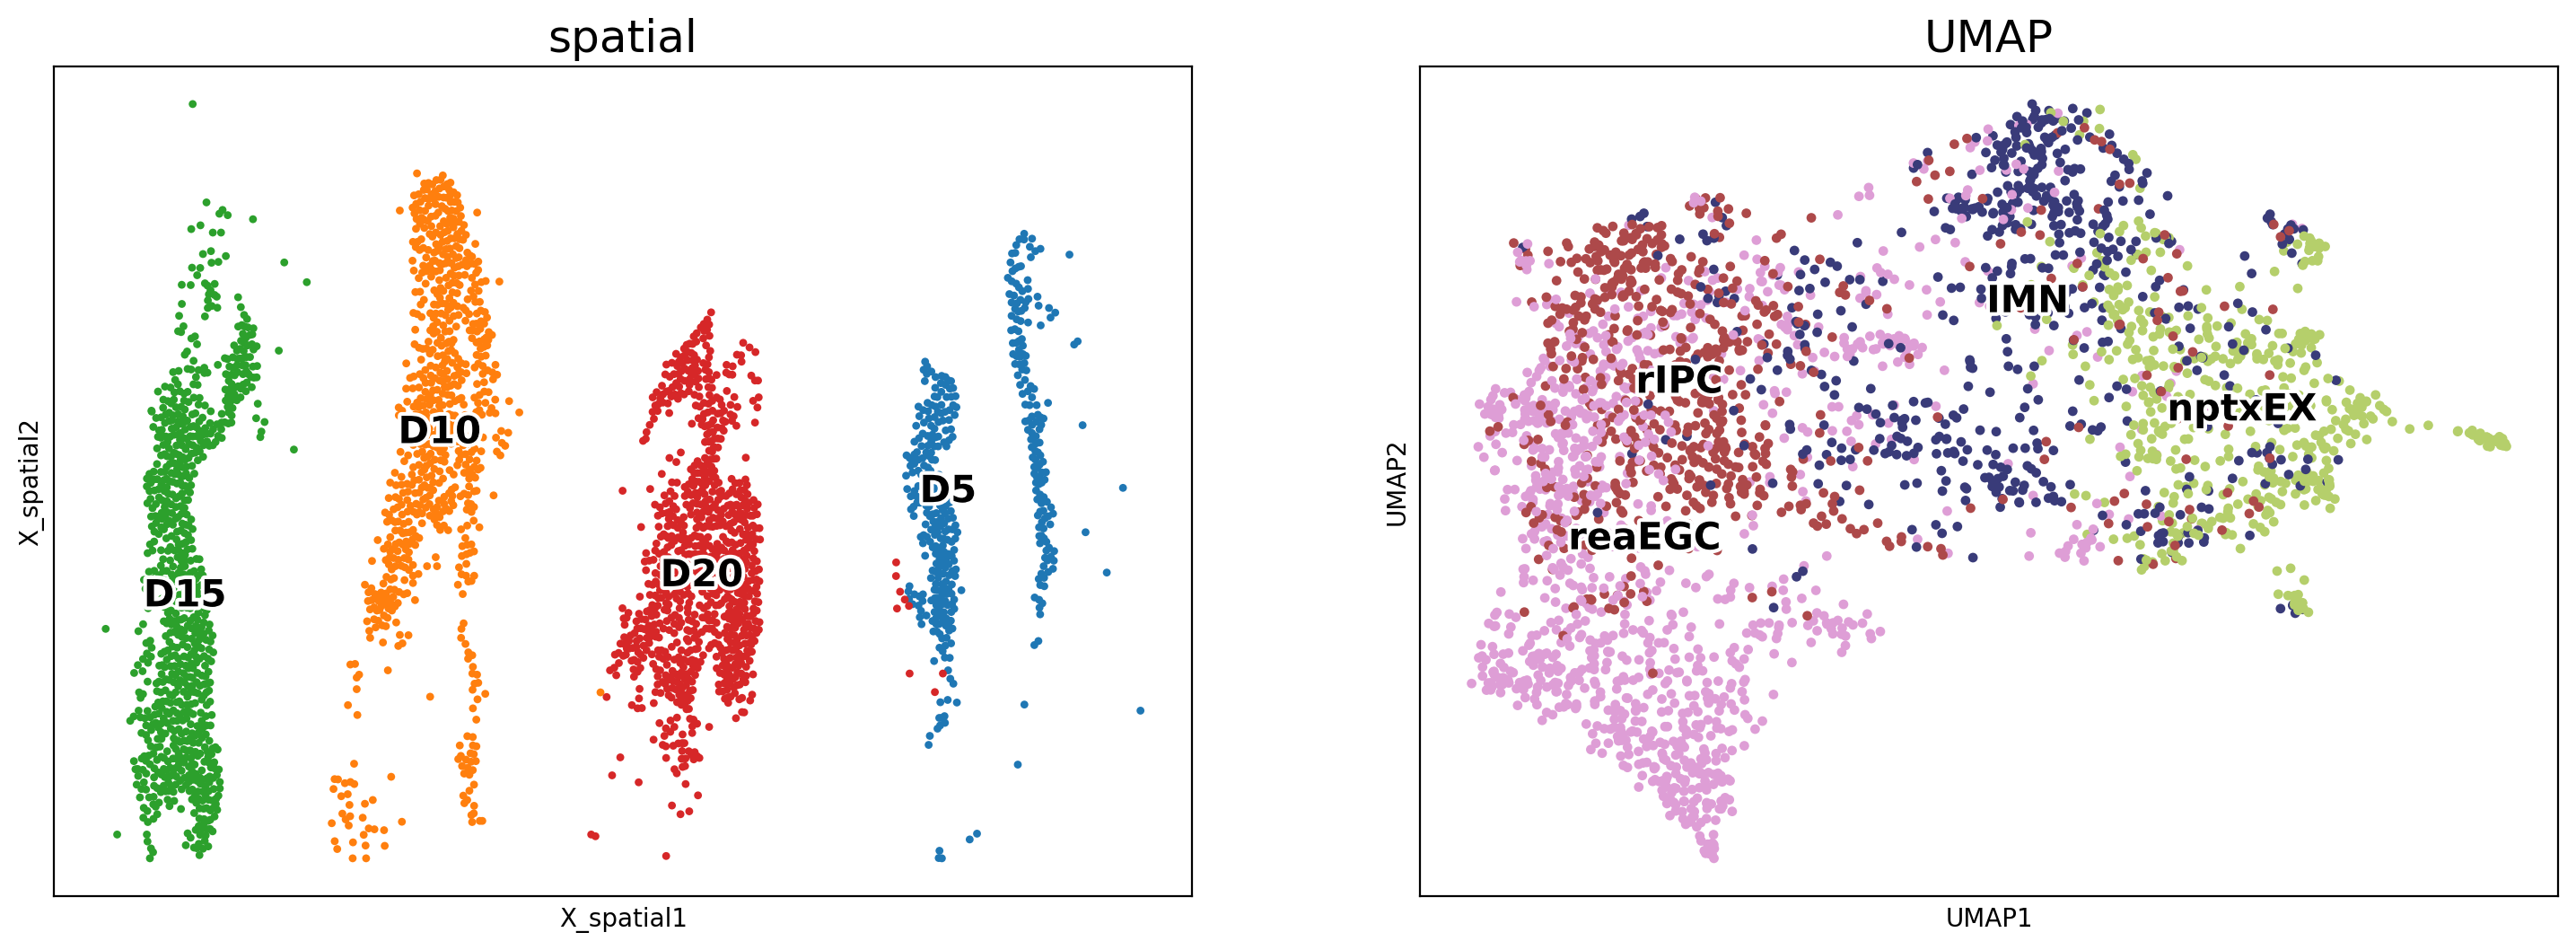

In [4]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(18, 6))
sc.pl.embedding(adata, basis='X_spatial', color='Time', size=50, legend_fontsize=15,legend_loc='on data', ax=axs[0], legend_fontoutline=3, show=False, s=40)
axs[0].set_title('spatial',fontsize=18)
sc.pl.umap(adata,color='cluster',ax=axs[1],legend_loc='on data',size=50,legend_fontoutline=3, legend_fontsize=15,palette='tab20b',show=False,s=60)
axs[1].set_title('UMAP',fontsize=18)

The cell types of interest were plotted in the ST slides at each time point using the spatial coordinates. 

In [5]:
adata.uns['cluster_colors']=['#5254a3', '#8c6d31','#EEDC82','#d6616b']

Text(0.5, 1.0, 'spatial')

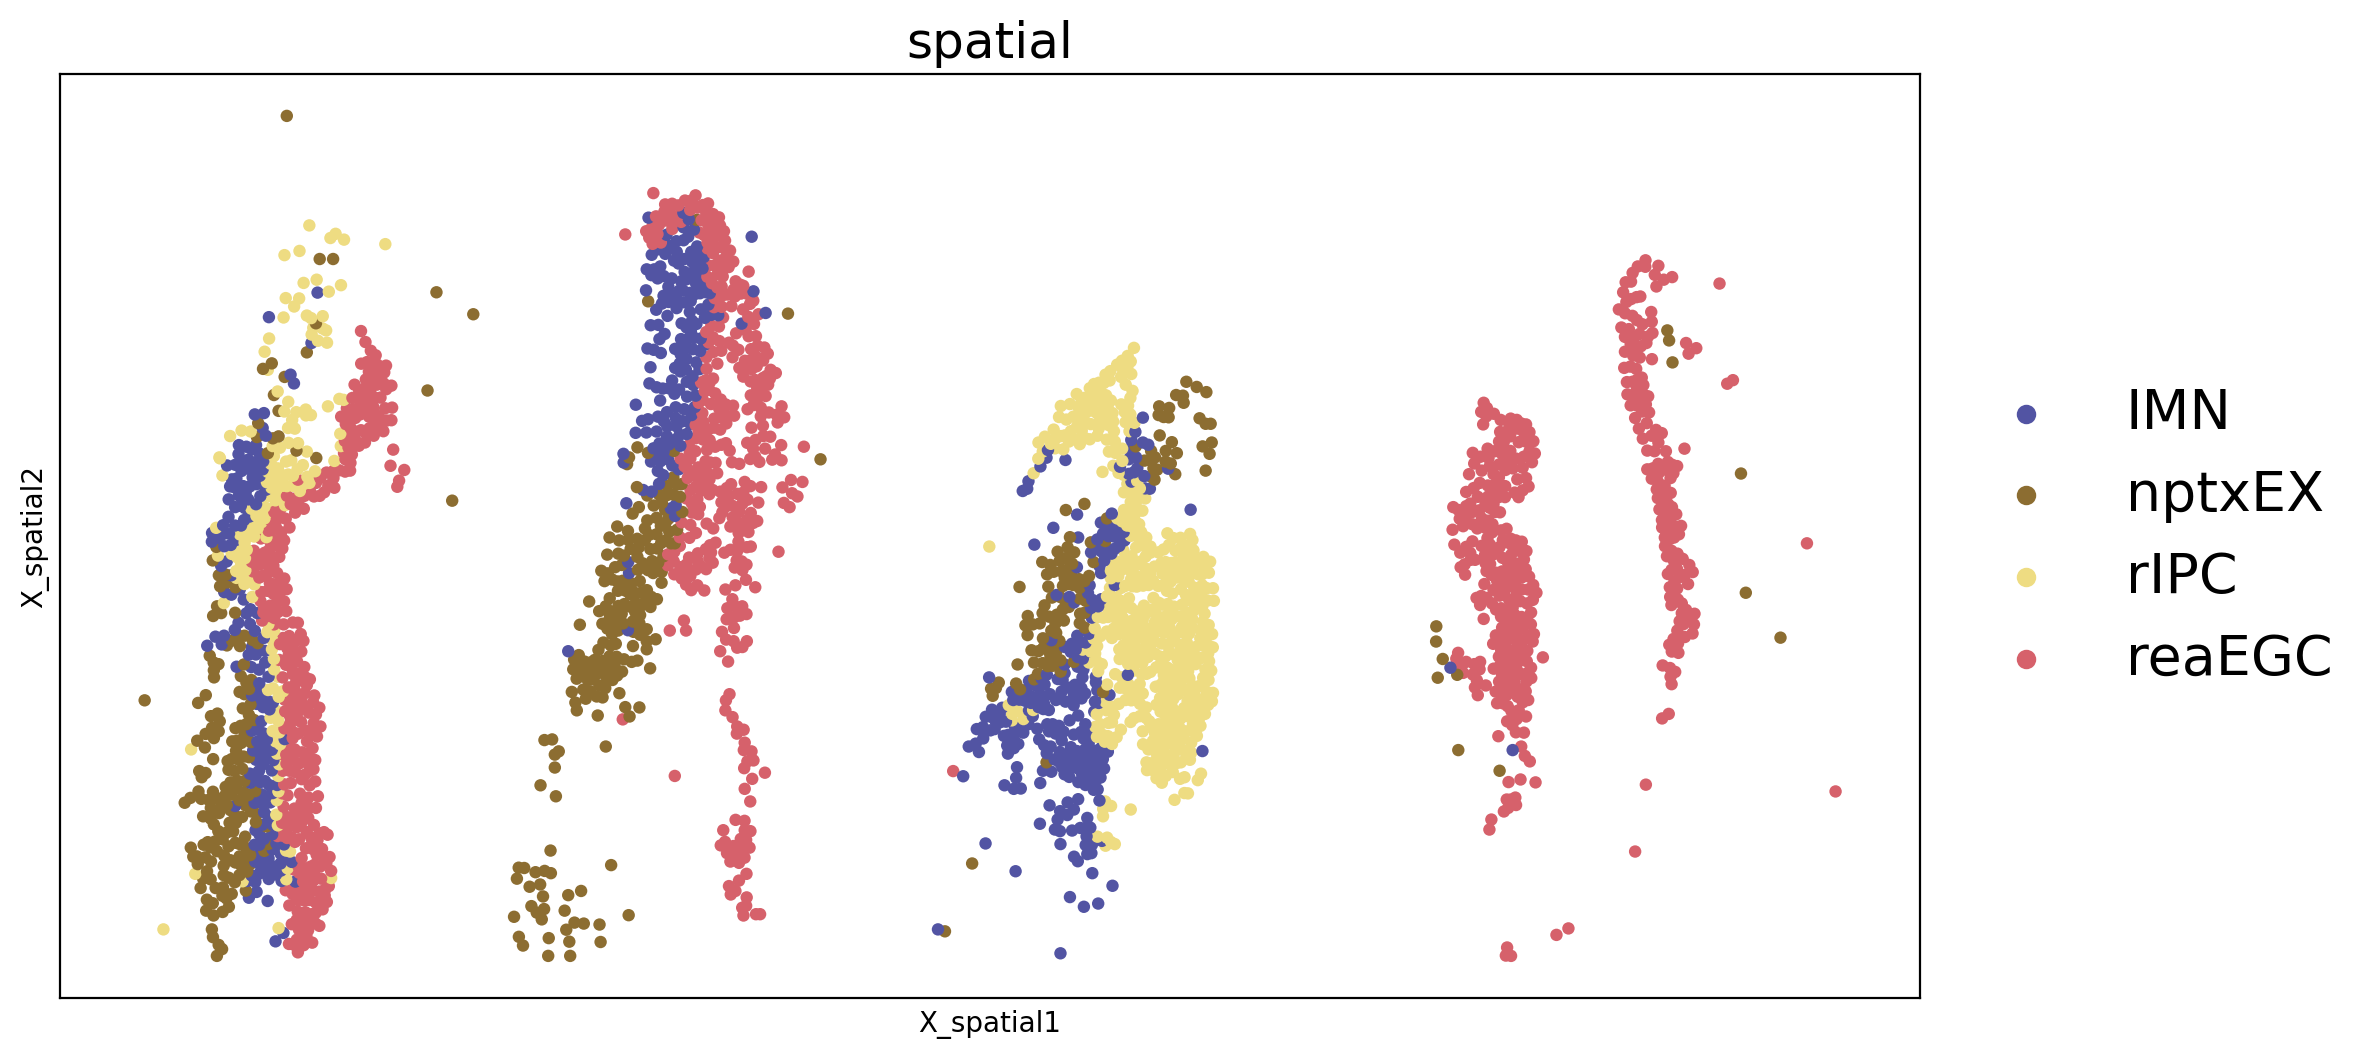

In [6]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(12, 6))
sc.pl.embedding(adata, basis='X_spatial', color='cluster', size=50, legend_loc='right margin', legend_fontsize=20,ax=axs, legend_fontoutline=3, show=False, s=80)
axs.set_title('spatial',fontsize=18)

## 2. Calculate cell-transition probability

We set the starting point of ST slides at each time point separately. Due to the disappearance of reaEGC at terminal time point D20, we used rIPC as the starting point based on the inferred trajectory in D15.
 
spaTrack implements an integrating framework to separately calculate cell-transition probability for each section and subsequently integrate all transition matrix to infer the complete trajectory. This scenario is suitable for multiple sections containing various cell types.

Next, we used UMAP embedding to calculate the cell velocity and plotted visualized trajectory lines.

In [7]:
time_and_start = {"D5": "reaEGC", "D10": "reaEGC", "D15": "reaEGC", "D20": "rIPC"}
alpha = {
    "D5": [0.693, 0.307],
    "D10": [0.7, 0.3],
    "D15": [0.75, 0.25],
    "D20": [0.704, 0.296],
}

P_all = V_all = np.array([]).reshape(0, 2)

for time_point in time_and_start.keys():
    print(time_point)
    subadata = adata[adata.obs["Time"] == time_point]
    subadata.obsp["trans"] = spt.get_ot_matrix(subadata, data_type="spatial",alpha1=alpha[time_point][0],alpha2=alpha[time_point][1])
    start_cluster = time_and_start[time_point]
    start_cells = spt.set_start_cells(
        subadata, select_way="cell_type", cell_type=start_cluster
    )
    subadata.obs["ptime"] = spt.get_ptime(subadata, start_cells)
    _, _ = spt.get_velocity(subadata, basis="umap", n_neigh_pos=80, n_neigh_gene=0)

    P_all = np.vstack((P_all, subadata.obsm["X_umap"]))
    V_all = np.vstack((V_all, subadata.obsm["velocity_umap"]))

D5
X_pca is not in adata.obsm, automatically do PCA first.
alpha1(gene expression): 0.693   alpha2(spatial information): 0.307
The velocity of cells store in 'velocity_umap'.
D10
X_pca is not in adata.obsm, automatically do PCA first.
alpha1(gene expression): 0.7   alpha2(spatial information): 0.3
The velocity of cells store in 'velocity_umap'.
D15
X_pca is not in adata.obsm, automatically do PCA first.
alpha1(gene expression): 0.75   alpha2(spatial information): 0.25
The velocity of cells store in 'velocity_umap'.
D20
X_pca is not in adata.obsm, automatically do PCA first.
alpha1(gene expression): 0.704   alpha2(spatial information): 0.296
The velocity of cells store in 'velocity_umap'.


## 3. Visualize cell trajectory of multiple ST samples

To calculate cell velocity, we only considered neighbor cells separately at each time point. 

After calculating cell velocity, we converted it to grid velocity for visualizing the trajectory. 

In [8]:
P_grid, V_grid = spt.velocity.get_velocity_grid(
    adata, P=P_all, V=V_all
)

Visualization of trajectory on UMAP coordinates

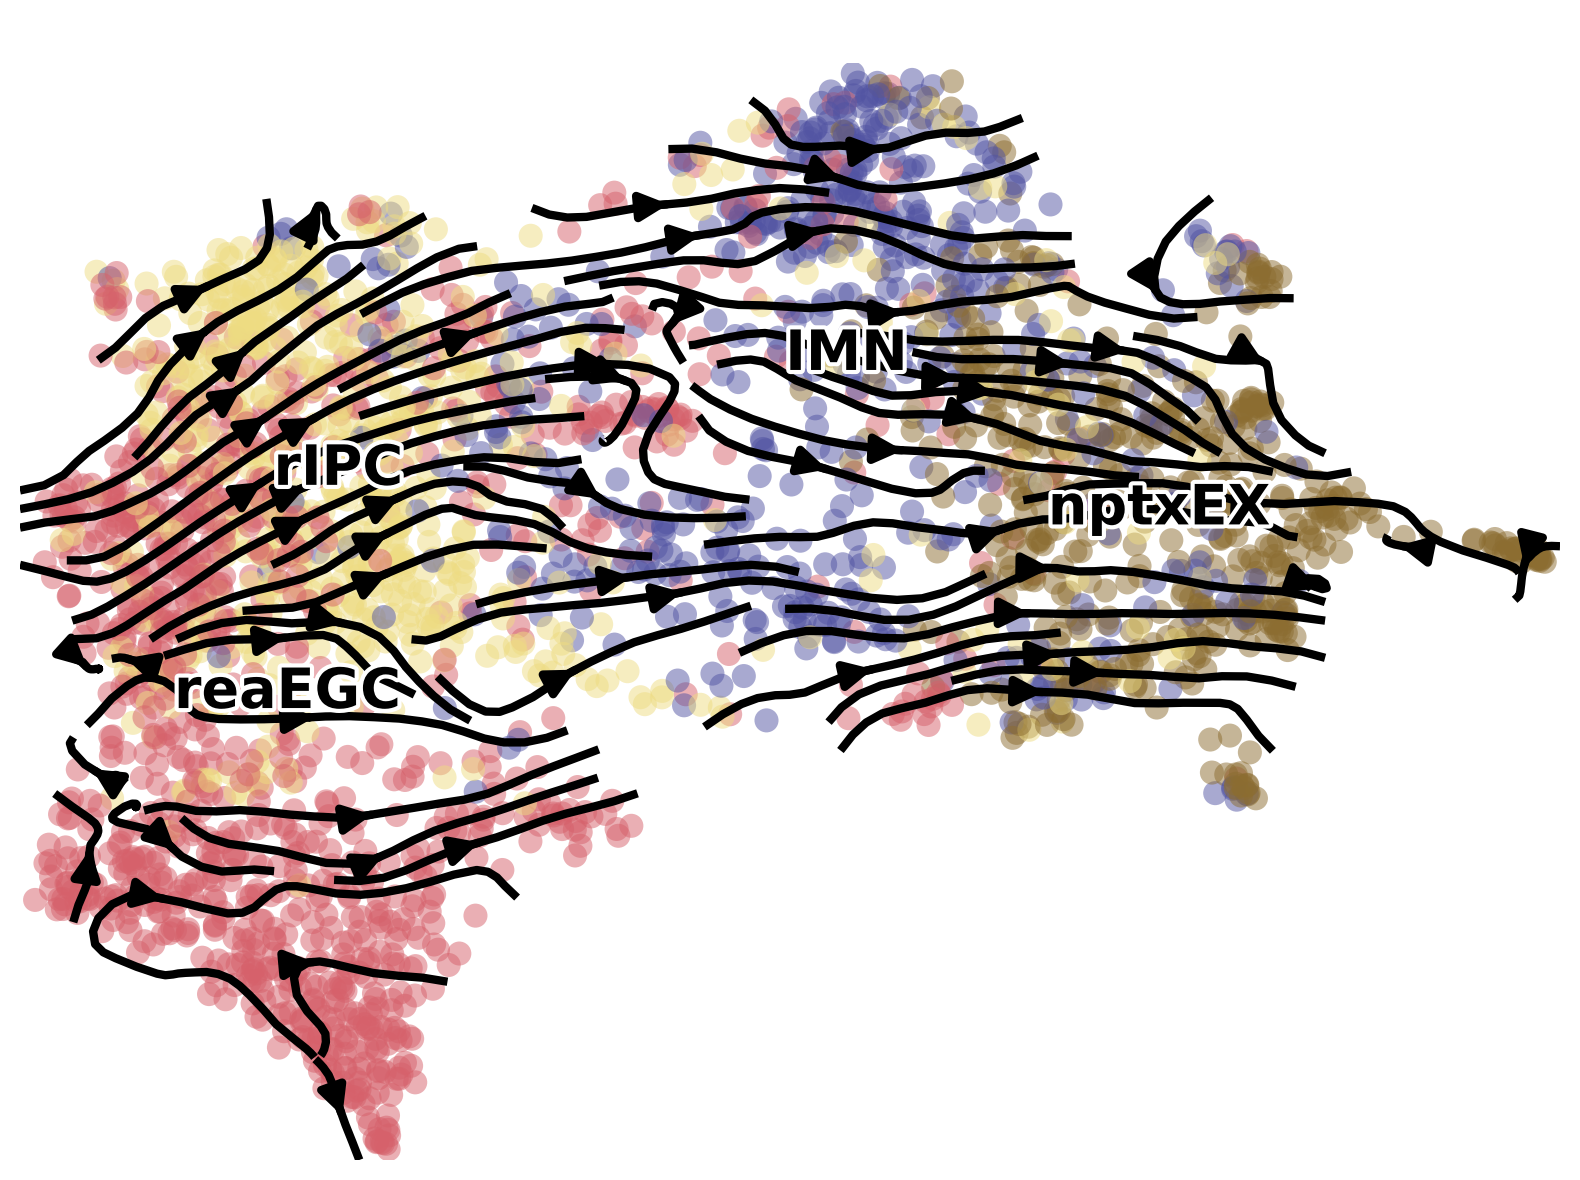

In [9]:
fig,axs=plt.subplots(ncols=1,nrows=1,figsize=(8,6))

ax = sc.pl.embedding(adata, basis ='X_umap',show=False,color='cluster',ax=axs,legend_loc='on data',frameon=False,title=' ',legend_fontsize=20,
                     legend_fontoutline =3,legend_fontweight='bold',alpha=0.5,size=300)

ax.streamplot(adata.uns['P_grid'][0], adata.uns['P_grid'][1], adata.uns['V_grid'][0], adata.uns['V_grid'][1],density=2,color='black',linewidth=3,arrowsize=2,minlength=0.2,maxlength=0.8)

plt.tight_layout()